# Lunar Lander 

## implementing policy gradients: algoritmo Básico "on policy"

In [1]:
import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F 

from torch.distributions import Bernoulli    # para la parte de exploración: distribución de probabilidades de las acciones
from torch.distributions import Categorical
from torch.autograd import Variable          # para instanciar variables diferenciables en los gradientes: backpropagation
from itertools import count

### Explorando el enviroment

In [2]:
env = gym.make('LunarLander-v2')
env.reset()

print(f'El espacio de obervaciones para el Lunar lander es de: {env.observation_space.shape[0]}')
print(f'Espacio de acciones para el Lunar Lander: {env.action_space.n}')

El espacio de obervaciones para el Lunar lander es de: 8
Espacio de acciones para el Lunar Lander: 4


In [3]:
state = env.reset()
print(state[0])

[-0.00384274  1.4114405  -0.38925165  0.02311456  0.00445966  0.08817134
  0.          0.        ]


### Definiendo la policy network

In [4]:
class PolicyNet(nn.Module): 
    def __init__(self, input_size, num_actions):
        super(PolicyNet, self).__init__() 

        # arquitectura de la red 
        self.fc1 = nn.Linear(in_features=input_size, out_features=16*input_size)
        self.fc2 = nn.Linear(in_features=16*input_size, out_features=32*input_size)
        self.fc3 = nn.Linear(in_features= 32*input_size, out_features=num_actions)

    def forward(self, x):
        # Se definen las operaciones del forward
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=-1)  # Especificar la dimensión
        
        return x 

### Definiendo hiper parámetros

In [5]:
episodes = 5_000
max_steps_in_episode = 2500
episode_duration = []      # almacenar la duracion de los episodios
episode_mean_rewards = []  # almacenar la recompensa media de cada episodio
model_path = 'LunarLander_pg.pth'

# hiper parametros del entrenamiento
learning_rate = 0.001
gamma = 0.95
batch_size = 16

# se define el enviroment y la policy
env = gym.make('LunarLander-v2')
policy_net = PolicyNet(input_size=env.observation_space.shape[0], num_actions=env.action_space.n)

# optimizador 

optimizer = torch.optim.Adam(
    params=policy_net.parameters(), 
    lr= learning_rate
)

state_pool = []
action_pool = []
reward_pool = []
steps = 0

### Entrenamiento

In [6]:
def process_state(state): 
    state = torch.from_numpy(state).float()
    return Variable(state)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device)

PolicyNet(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [8]:
# bucle de episodios
for eps in range(episodes):

    print(f'Inicializando el episodio: {eps}')
    state = env.reset()
    state = process_state(state=state[0]).to(device)

    episode_rewards = []
    
    # bucle de trayectorias
    for t in range(max_steps_in_episode): 

        # seleccionar una accion dado el estado y la policy actual
        probs = policy_net(state)


        # print(f"State: {state}")
        # print(f"Probs: {probs}")
        
        if torch.isnan(probs).any():
            raise ValueError("Probs contiene NaN")
        
        m = Categorical(probs= probs)
        action = m.sample()
        action = action.item()

        # ejecuttamos un step en el entorno con nuestra action
        next_state, reward, done, truncated,  _ = env.step(action=action)

        # almacenamos experiencia
        state_pool.append(state)
        action_pool.append(float(action))
        episode_rewards.append(reward)

        # procesamos el siguiente estado
        state = process_state(next_state).to(device)

        steps += 1

        if done: 
            episode_duration.append(t+1)
            episode_mean_rewards.append(np.mean(episode_rewards))
            print(f'Finaliza el episodio: {eps}\n\t\tduración: {t} steps\n\t\trecompensa promedio: {np.mean(episode_rewards)}\n\n')
            break
    else: 
        episode_duration.append(max_steps_in_episode)
        episode_mean_rewards.append(np.mean(reward_pool))
        print(f'Finaliza el episodio: {eps}\n\t\tduración: {t+1} steps\n\t\trecompensa promedio: {np.mean(episode_rewards)}\n\n')

    # calcular la recompensa acumulada para cada step EN CADA EPISODIO
    discount_reward = 0
    for n in reversed(range(len(episode_rewards))): 
        discount_reward = episode_rewards[n] + gamma*discount_reward
        episode_rewards[n] = discount_reward

    # normalizamos la recompensa
    reward_mean = np.mean(episode_rewards)
    reward_std = np.std(episode_rewards)
    norm_episode_rewards = [(episode_rewards[n] - reward_mean)/(reward_std+ 1e-9) for n in range(len(episode_rewards))]
    
    reward_pool.extend(norm_episode_rewards)

    # update policy; actualizamos la policy cada 5 trayectorias recopiladas
    if eps >0 and eps% batch_size == 0: 
        print('\t\tActualizando la policy...')

        # actualizar la policy
        optimizer.zero_grad()
        total_loss = 0
        for n in range(steps): 
            
            state = state_pool[n]
            action = Variable(torch.tensor(action_pool[n], dtype=torch.float32)).to(device)

            reward = reward_pool[n]
            probs = policy_net(state)           # le damos a la policy el nuevo estado 
            m = Categorical(probs=probs)        # sacamos las probs para cada accion
            loss = -m.log_prob(action)*reward   # negative score  function x reward; calculamos la pérdida de cada accion por su recompensa
            total_loss += loss
            
        # calcular gradientes
        total_loss.backward()

        # actualizamos los pesos en direccion de los gradientes
        optimizer.step()  
        print('\t\tPolicy actualizada con éxito!\n')   

        # limpiamos la memoria (cada vez que termino un entreno)
        state_pool = []
        action_pool = []
        reward_pool = []
        steps = 0

Inicializando el episodio: 0
Finaliza el episodio: 0
		duración: 118 steps
		recompensa promedio: -3.904633683222178


Inicializando el episodio: 1
Finaliza el episodio: 1
		duración: 67 steps
		recompensa promedio: -1.2460126974591148


Inicializando el episodio: 2
Finaliza el episodio: 2
		duración: 72 steps
		recompensa promedio: -2.9600312660728303


Inicializando el episodio: 3
Finaliza el episodio: 3
		duración: 83 steps
		recompensa promedio: -1.153685522733871


Inicializando el episodio: 4
Finaliza el episodio: 4
		duración: 149 steps
		recompensa promedio: -2.1850919086006253


Inicializando el episodio: 5
Finaliza el episodio: 5
		duración: 78 steps
		recompensa promedio: -2.611300529216462


Inicializando el episodio: 6
Finaliza el episodio: 6
		duración: 108 steps
		recompensa promedio: -1.6842525547017073


Inicializando el episodio: 7
Finaliza el episodio: 7
		duración: 115 steps
		recompensa promedio: -2.752271354408987


Inicializando el episodio: 8
Finaliza el episodi

/home/mikel/miniconda3/envs/venv_rl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mikel/miniconda3/envs/venv_rl/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Finaliza el episodio: 769
		duración: 2500 steps
		recompensa promedio: -0.11960261950034942


Inicializando el episodio: 770
Finaliza el episodio: 770
		duración: 116 steps
		recompensa promedio: -0.15331440852203326


Inicializando el episodio: 771
Finaliza el episodio: 771
		duración: 189 steps
		recompensa promedio: -0.6111975647140924


Inicializando el episodio: 772
Finaliza el episodio: 772
		duración: 227 steps
		recompensa promedio: -0.511465963294573


Inicializando el episodio: 773
Finaliza el episodio: 773
		duración: 167 steps
		recompensa promedio: -1.1562397760035459


Inicializando el episodio: 774
Finaliza el episodio: 774
		duración: 310 steps
		recompensa promedio: -0.24648747776172572


Inicializando el episodio: 775
Finaliza el episodio: 775
		duración: 1812 steps
		recompensa promedio: -0.234566499458389


Inicializando el episodio: 776
Finaliza el episodio: 776
		duración: 221 steps
		recompensa promedio: -0.002300488725224983


Inicializando el episodio: 777
Fin

KeyboardInterrupt: 

In [9]:
torch.save(policy_net.state_dict(), model_path)

### Monitoreando los resultados

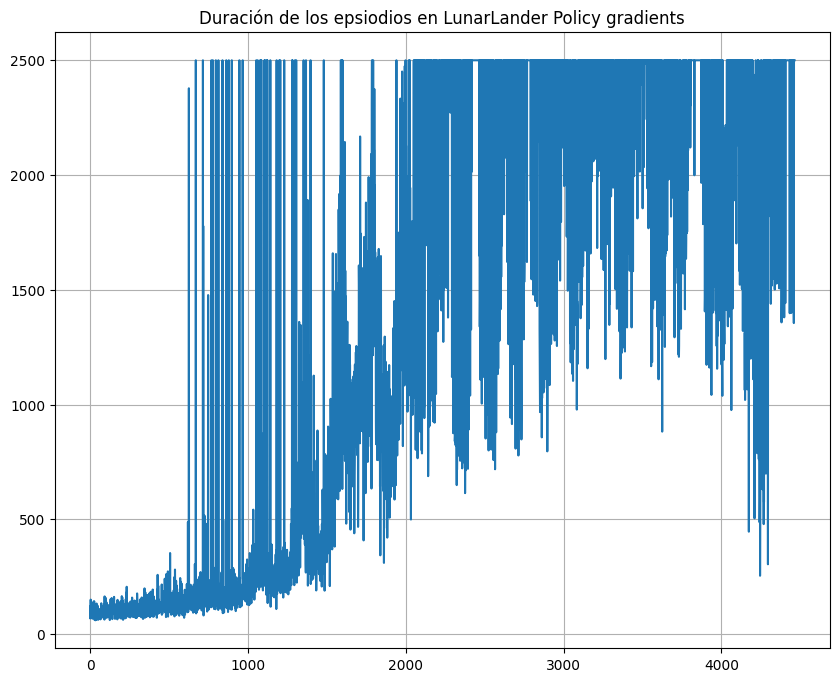

In [10]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 8))
plt.plot(range(len(episode_duration)), episode_duration)
plt.title('Duración de los epsiodios en LunarLander Policy gradients')
plt.grid()
plt.show()

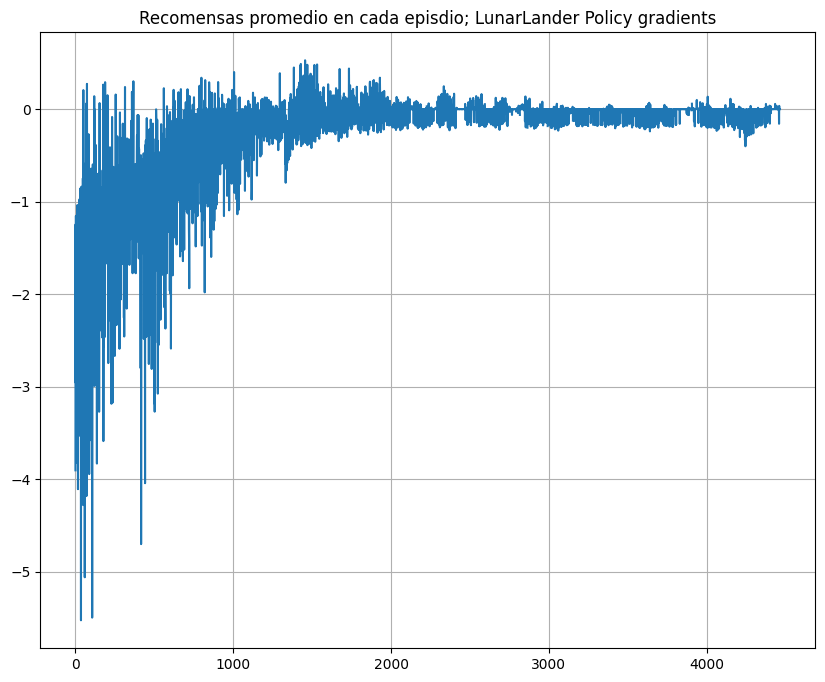

In [11]:
plt.figure(figsize= (10, 8))
plt.plot(range(len(episode_mean_rewards)), episode_mean_rewards)
plt.title('Recomensas promedio en cada episdio; LunarLander Policy gradients')
plt.grid()
plt.show()